In [88]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
import time

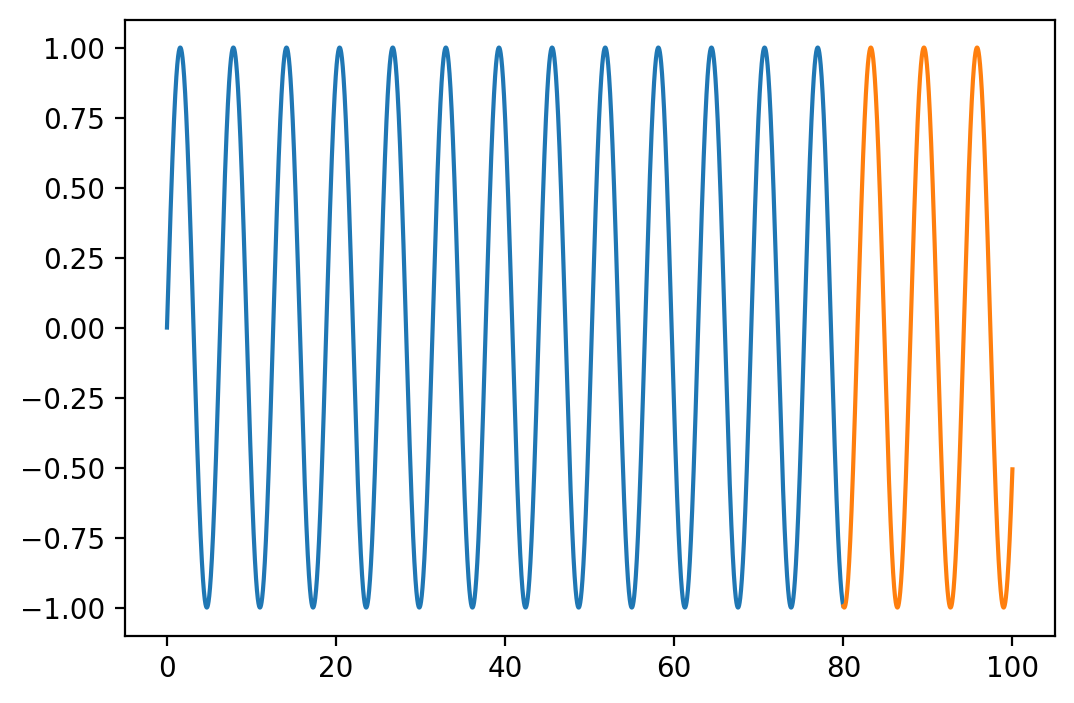

In [56]:
# sine dataset
X_whole = torch.linspace(0, 100, 10000)
y_whole = torch.sin(X_whole)

# split into train and test
X_train = X_whole[:8000]
y_train = y_whole[:8000]

X_test = X_whole[8000:]
y_test = y_whole[8000:]

# plot
plt.figure(figsize=(6, 4))
plt.plot(X_train, y_train, label='train')
plt.plot(X_test, y_test, label='test')


In [57]:
y_train.shape

torch.Size([8000])

In [58]:
context_length = 100 # history
prediction_length = 10 # future to predict

In [59]:
class MLP(nn.Module):
    def __init__(self, input_dim, prediction_length):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, prediction_length)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    


In [60]:
i = 0
y_train[i:i+context_length].shape, y_train[i+context_length:i+context_length+prediction_length].shape

(torch.Size([100]), torch.Size([10]))

In [72]:
# create training data
def create_train_data(X, y, context_length, prediction_length):
    Xs, ys = [], []
    for i in range(len(X) - context_length - prediction_length):
        Xs.append(y[i:i+context_length])
        ys.append(y[i+context_length:i+context_length+prediction_length])
    return torch.stack(Xs), torch.stack(ys)


In [73]:
Xs, ys = create_train_data(X_train, y_train, context_length, prediction_length)

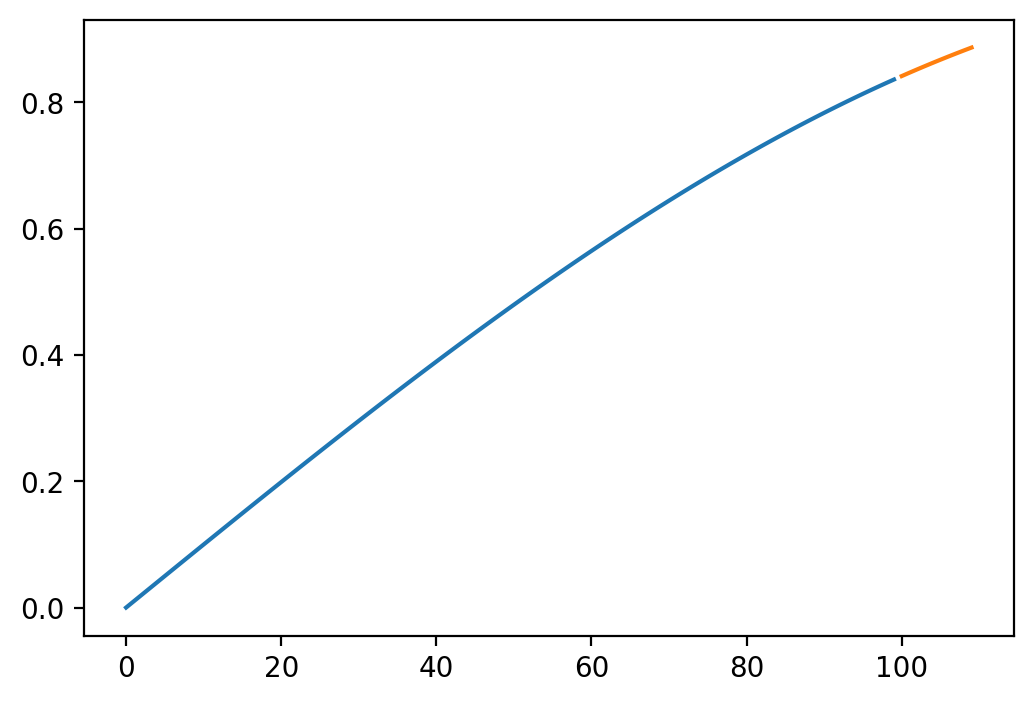

In [74]:
# Plot the first training data example
plt.figure(figsize=(6, 4))
plt.plot(Xs[0], label='context (history)')
plt.plot(range(context_length, context_length+prediction_length), ys[0], label='prediction (future)')

In [104]:
mlp = MLP(context_length, prediction_length)
print("Number of parameters:", sum(p.numel() for p in mlp.parameters()))

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# training loop
n_epochs = 100
start_time = time.time()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = mlp(Xs)
    loss = criterion(y_pred, ys)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch} - Loss {loss.item():.4f} Time (s) {time.time() - start_time: .2f}')

Number of parameters: 47242
Epoch 0 - Loss 0.4968 Time (s)  0.02
Epoch 10 - Loss 0.1697 Time (s)  0.15
Epoch 20 - Loss 0.0666 Time (s)  0.28
Epoch 30 - Loss 0.0046 Time (s)  0.41
Epoch 40 - Loss 0.0038 Time (s)  0.54
Epoch 50 - Loss 0.0019 Time (s)  0.64
Epoch 60 - Loss 0.0004 Time (s)  0.74
Epoch 70 - Loss 0.0002 Time (s)  0.84
Epoch 80 - Loss 0.0001 Time (s)  0.97
Epoch 90 - Loss 0.0001 Time (s)  1.12


In [93]:
X_test.shape, y_test.shape

(torch.Size([2000]), torch.Size([2000]))

In [94]:
# Test data
Xs_test, ys_test = create_train_data(X_test, y_test, context_length, prediction_length)

In [95]:
Xs_test.shape, ys_test.shape

(torch.Size([1890, 100]), torch.Size([1890, 10]))

In [96]:
y_hat = mlp(Xs_test)

# compute the loss
with torch.no_grad():
    loss = criterion(y_hat, ys_test)
print(f'Test Loss: {loss.item():0.4f}')

Test Loss: 5.9333124227123335e-05


In [97]:
Xs_test.shape, y_hat.shape

(torch.Size([1890, 100]), torch.Size([1890, 10]))

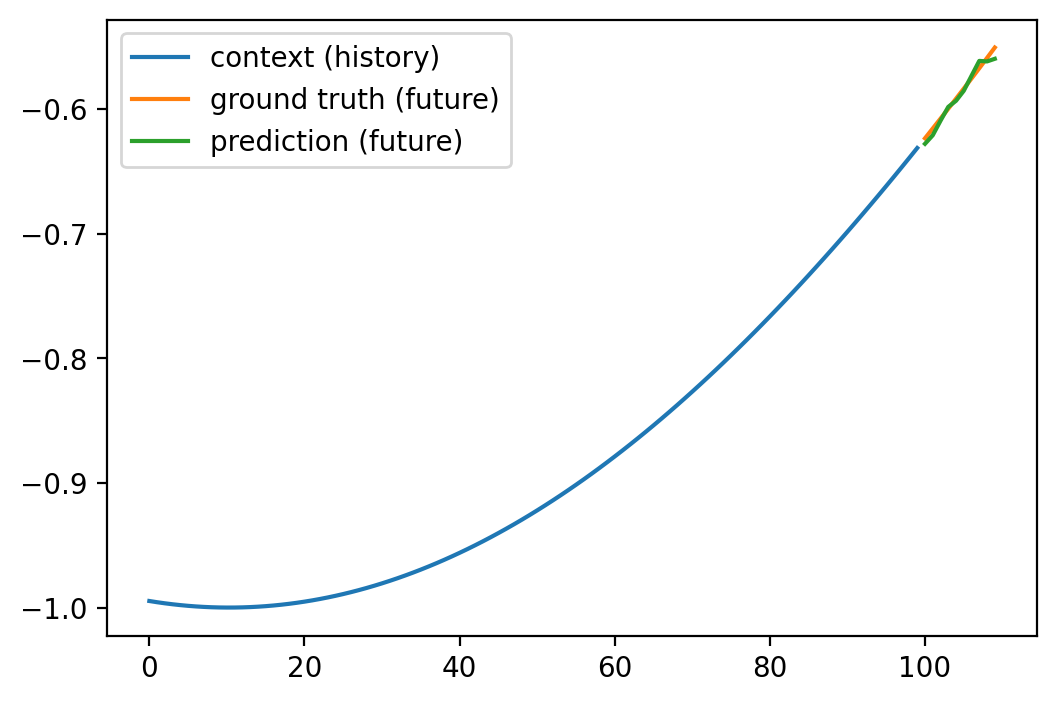

In [98]:
# Plot the first test data example
def plot_prediction(i):
    plt.figure(figsize=(6, 4))
    plt.plot(Xs_test[i], label='context (history)')
    plt.plot(range(context_length, context_length+prediction_length), ys_test[i], label='ground truth (future)')
    plt.plot(range(context_length, context_length+prediction_length), y_hat[i].detach().numpy(), label='prediction (future)')
    plt.legend()

plot_prediction(0)

In [108]:
# Simple Transformer

class Transformer(nn.Module):
    def __init__(self, input_dim, prediction_length, num_heads=8, num_layers=3):
        super(Transformer, self).__init__()
        self.prediction_length = prediction_length
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.emb = nn.Linear(input_dim, 32)
        encoder_layer = nn.TransformerEncoderLayer(d_model=32, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(32, prediction_length)
        
    def forward(self, x):
        x = self.emb(x)
        x = self.transformer_encoder(x)
        x = self.fc(x)
        return x

In [110]:
transormer = Transformer(context_length, prediction_length, num_heads=4, num_layers=3)
print("Number of parameters:", sum(p.numel() for p in transormer.parameters()))
optimizer = torch.optim.Adam(transormer.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# training loop
n_epochs = 100

start_time = time.time()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = transormer(Xs)
    loss = criterion(y_pred, ys)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch} - Loss {loss.item():.4f} Time {time.time() - start_time: .2f}')
    


Number of parameters: 416074
Epoch 0 - Loss 1.0997 Time  22.90
Epoch 10 - Loss 0.0648 Time  181.78
Epoch 20 - Loss 0.0348 Time  292.99
Epoch 30 - Loss 0.0191 Time  410.26


KeyboardInterrupt: 

In [111]:
# Prediction 

with torch.no_grad():
    y_hat = transormer(Xs_test)
    loss = criterion(y_hat, ys_test)
    print(f'Test Loss: {loss.item()}')  

Test Loss: 0.017046289518475533


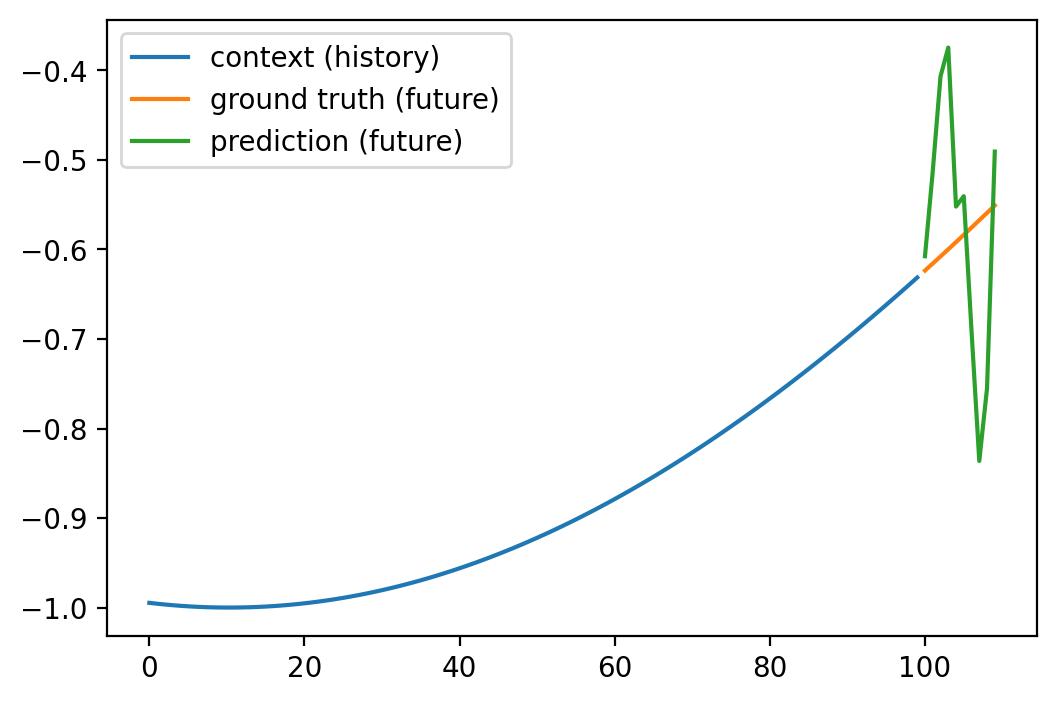

In [112]:
# Plot the first test data example
plot_prediction(0)

In [114]:
from transformers import InformerForPrediction, InformerConfig

config = InformerConfig(
    input_dim=context_length,
    prediction_length=prediction_length,
    num_heads=4,
    encoder_layers=2,
    decoder_layers=2,
    use_mask=True,
    forecast=True
)

informer = InformerForPrediction(config)

In [116]:
sum(p.numel() for p in informer.parameters())

134531

In [117]:
# training loop
n_epochs = 100

start_time = time.time()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = informer(Xs, past


TypeError: forward() missing 2 required positional arguments: 'past_time_features' and 'past_observed_mask'